# Large scale statistical tests in BigQuery

```
Created: 09-08-2021
Purpose: Compute correlations between proteomic and gene expression available in the TCGA 
```
This notebook uses BigQuery to compute Pearson correlation between protein and gene expression for all the genes in the BigQuery tables of the TCGA. We used Breast cancer (BRCA) as example; but this can be changed easily for other cancer types.

## Benefits of BigQuery for data analysis 
It is possible to perform large scale statistical tests in the cloud, using the BigQuery tables available in ISB-CGC. Importantly, 
BigQuery allows you to get a cluster power; without having to manage a cluster. The following figure shows the how the computational time changes with the number of tests (Correlation, and t-tests) computed in BigQuery.

![title](img/CompTime_BigQuery2.png)

**Example:**
We recently computed ~100 million correlations and p-value computations in about 20 min. in BigQuery (hours/days on your personal machine)


## User Defined Functions: UDFs
BigQuery now supports User Defined Functions (UDFs) in SQL and JavaScript that extend BigQuery for more specialized computations and that can be reused in notebooks and queries. 

UDFs provide an easy way to perform complex operations in the cloud, taking advantage of the high computational power available in Google Cloud. We developed a collection of UDFs that implement commonly used statistical tests and methods in cancer research and bioinformatics. The UDFs are located in the isb-cgc-bq.functions data set, and the source code of the functions and examples of how to use them can be found in our Community Notebook GitHub Repository. The following table show some functions available in ISB-CGC.

| UDF name | Description |
| :--- | :--- |
| corr_pvalue | Computes p values for correlation coeficients |
| BHmultipletests | Adjust p values for multiple testing |
| p_fisherexact | p value of the Fisher exact test |
| mannwhitneyu | Mann–Whitney U test |
| kruskal_walis | Kruskal Walis test |





## Use case: Compute correlations and their p-values

In [3]:
install.packages("bigrquery")

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



## Libraries

In [102]:
library(bigrquery)
library(stringr)
library(ggplot2)
bigrquery::bq_auth(path = "~/key-file")
project <- 'isb-cgc-outreach'

## Parameters and  technical terms

| Name | Description |
| :--- | :--- |
| isb-cgc-bq | Google project name of ISB-CGC |
| RNAseq_hg38_gdc_current | Gene expression |
| protein_expression_hg38_gdc_current | Protein expression |
| HTSeq__Counts | Number of mapped reads to each gene as calculated by package HTSeq |




In [103]:
# Parameters: cancer type
cancer_type <- "TCGA-BRCA"

## Retrieve gene expression.
The following query will retrieve gene expression, barcodes, sample type ("cancer", "normal", or "metastatic"), gene names, and gene expression (HTSeq__Counts), from TCGA table isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current.
The results are group by gene names, sample type, and barcodes. This is used for agreegate gene expression for genes with multiple ensemble_gene_ids. 


In [104]:
sql1 <- "table1 AS (
   SELECT sample_barcode,aliquot_barcode, sample_type_name, gene_name,  Ensembl_gene_id, 
        LOG10( MAX(HTSeq__Counts) + 1 ) AS gene_exp 
   FROM
      `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current` 
   WHERE 
      gene_type = 'protein_coding'
      AND project_short_name = '__CANCER_TYPE__'
   GROUP BY sample_barcode,Ensembl_gene_id, gene_name, sample_type_name, aliquot_barcode
)
"
sql_ge <- gsub('__CANCER_TYPE__', cancer_type, sql1 )

## Retrieve protein expression.
The following query will retrieve protein expression and aliquot barcodes from TCGA table isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current. 

In [105]:
sql2 <- "table2 AS (
   SELECT sample_barcode,aliquot_barcode, gene_name,  
        AVG( protein_expression ) as prot_exp 
   FROM
      `isb-cgc-bq.TCGA.protein_expression_hg38_gdc_current` 
   WHERE 
      validation_status = 'V'
      AND project_short_name = '__CANCER_TYPE__'
   GROUP BY sample_barcode,aliquot_barcode, gene_name
)
"
sql_pe <- gsub('__CANCER_TYPE__', cancer_type, sql2 )

## Join tables
We can join the two tables and explore the data. 

In [106]:
# Build the query with all of the subqueries
myquery <- str_c("WITH ",sql_ge,",",sql_pe,"
SELECT gexp.sample_barcode, gexp.gene_name, gexp.Ensembl_gene_id, gexp.sample_type_name, 
       gexp.gene_exp, pexp.prot_exp 
FROM table1 gexp
JOIN table2 pexp
    ON gexp.sample_barcode = pexp.sample_barcode
    AND gexp.gene_name = pexp.gene_name
")
# Send the query and fetch the results into a dataframe
join_tbl <- bq_project_query (project, query = myquery) #Put data in temporary BQ table
join_data <- bq_table_download(join_tbl) #Put data into a dataframe
head(join_data)

sample_barcode,gene_name,Ensembl_gene_id,sample_type_name,gene_exp,prot_exp
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
TCGA-A2-A0YD-01A,PXN,ENSG00000089159,Primary Tumor,3.875235,0.11047091
TCGA-AO-A0JE-01A,PCNA,ENSG00000132646,Primary Tumor,3.990605,0.04369298
TCGA-A7-A13F-11A,NKX2-1,ENSG00000136352,Solid Tissue Normal,0.000000,-0.13882509
TCGA-BH-A0BP-01A,BECN1,ENSG00000126581,Primary Tumor,3.222976,-1.61178905
TCGA-BH-A1EU-01A,BECN1,ENSG00000126581,Primary Tumor,3.818358,0.06927078
TCGA-E9-A6HE-01A,KDR,ENSG00000128052,Primary Tumor,2.860937,0.39256514


In [94]:
print(nrow(join_data))

[1] 14260


### Compute Pearson correlation
To compute correlation of two numeric columns, we need to group the data using gene names and sample type. 

In [107]:
sql_co <- "correlation AS ( 
    SELECT gexp.gene_name, gexp.Ensembl_gene_id, gexp.sample_type_name,
        COUNT(*) as Nsamples,
        CORR( gexp.gene_exp, pexp.prot_exp) as corr 
    FROM table1 gexp
    JOIN table2 pexp
    ON gexp.sample_barcode = pexp.sample_barcode
        AND gexp.gene_name = pexp.gene_name
    GROUP BY gene_name, gexp.Ensembl_gene_id, gexp.sample_type_name
)
"
myquery <- str_c("WITH ",sql_ge,",",sql_pe,",",sql_co, "SELECT * from correlation")

corr_tbl <- bq_project_query (project, query = myquery) #Put data in temporary BQ table
corr_data <- bq_table_download(corr_tbl) #Put data into a dataframe
head(corr_data)

gene_name,Ensembl_gene_id,sample_type_name,Nsamples,corr
<chr>,<chr>,<chr>,<int>,<dbl>
FN1,ENSG00000115414,Primary Tumor,882,0.3668623
PIK3R2,ENSG00000105647,Primary Tumor,882,0.0104987
EIF4EBP1,ENSG00000187840,Solid Tissue Normal,36,0.1491474
ITGA2,ENSG00000164171,Solid Tissue Normal,36,0.2190247
G6PD,ENSG00000160211,Primary Tumor,882,0.5577776
ENY2,ENSG00000120533,Primary Tumor,733,0.3455463


In [96]:
print(nrow(corr_data))

[1] 124


### Compute P values

In [108]:
# Build the query with all of the subqueries
sql_pv = "
SELECT *, `cgc-05-0042.functions.corr_pvalue`(corr, Nsamples) AS pvalue
FROM correlation
ORDER BY pvalue
"
myquery <- str_c("WITH ",sql_ge,",",sql_pe,",",sql_co,sql_pv)

corr_tbl <- bq_project_query (project, query = myquery) #Put data in temporary BQ table
corr_data <- bq_table_download(corr_tbl) #Put data into a dataframe
head(corr_data)

gene_name,Ensembl_gene_id,sample_type_name,Nsamples,corr,pvalue
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
ESR1,ENSG00000091831,Primary Tumor,882,0.8114324,2.217067e-207
ERBB2,ENSG00000141736,Primary Tumor,882,0.7839685,2.550308e-184
BCL2,ENSG00000171791,Primary Tumor,882,0.7730227,4.738713e-176
AR,ENSG00000169083,Primary Tumor,882,0.7566643,1.600889e-164
CCNE1,ENSG00000105173,Primary Tumor,882,0.7510146,9.451461e-161
GATA3,ENSG00000107485,Primary Tumor,882,0.7486965,3.116025e-159


### Adjust pvalues for multiple testing

In [109]:
sqlBH = str_c ("
DECLARE Nrows INT64;
CREATE TEMP TABLE PearsonCorrelation AS
WITH ", 
sql_ge,",",sql_pe,",",sql_co,sql_pv,
";
SET Nrows = ( SELECT COUNT(*) FROM PearsonCorrelation );
CALL `cgc-05-0042.functions.BHmultipletests`( 'PearsonCorrelation', 'pvalue', Nrows )" )


In [110]:
options(scipen=20)
adjp_tbl <- bq_project_query (project, query = sqlBH) #Put data in temporary BQ table
adjp_data <- bq_table_download(adjp_tbl) #Put data into a dataframe
head(adjp_data)

gene_name,Ensembl_gene_id,sample_type_name,Nsamples,corr,pvalue,p_adj
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
ESR1,ENSG00000091831,Primary Tumor,882,0.8114324,2.217067e-207,8.668733e-205
ERBB2,ENSG00000141736,Primary Tumor,882,0.7839685,2.550308e-184,4.985853e-182
BCL2,ENSG00000171791,Primary Tumor,882,0.7730227,4.738713e-176,6.176123e-174
AR,ENSG00000169083,Primary Tumor,882,0.7566643,1.600889e-164,1.564869e-162
CCNE1,ENSG00000105173,Primary Tumor,882,0.7510146,9.451461e-161,7.391043e-159
GATA3,ENSG00000107485,Primary Tumor,882,0.7486965,3.116025e-159,2.030610e-157


In [111]:
nrow( adjp_data )

[1] 391

### Histogram of correlations

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



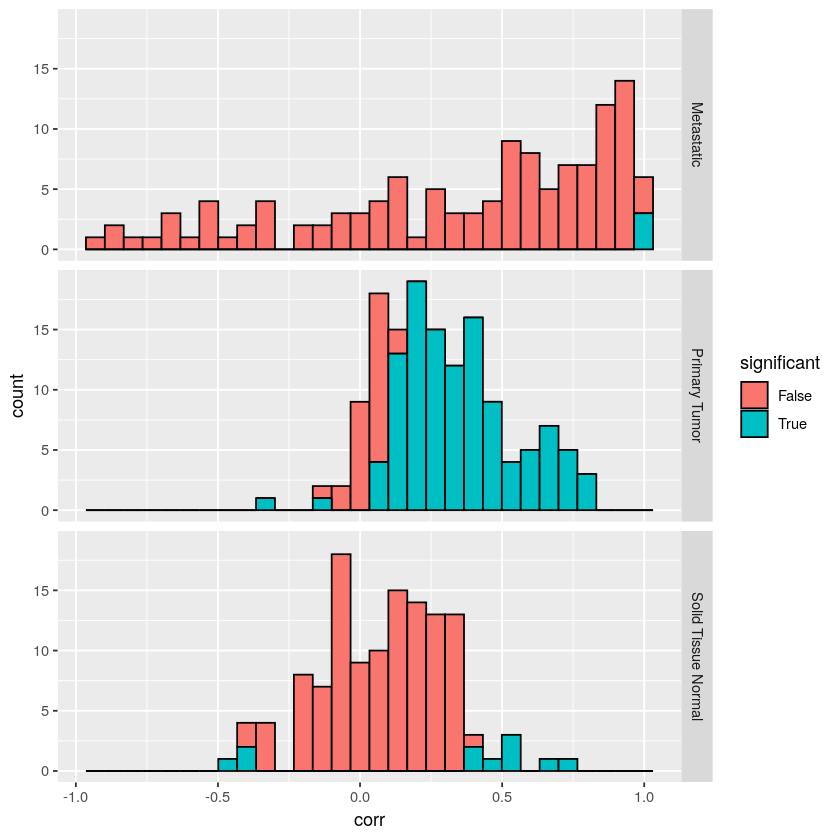

In [112]:
adjp_data$significant <- ifelse(adjp_data$p_adj >=0.05, 'False', 'True')

p<-ggplot(adjp_data, aes(x=corr, fill=significant))+
  geom_histogram(color="black")+
  facet_grid(sample_type_name ~ .)
p